In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import transforms, datasets
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
from tqdm import tqdm

In [18]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [19]:
# Hyperparameters
image_size = 224
patch_size = 16
num_classes = 7
hidden_dim = 256
depth = 6
num_heads = 4
mlp_dim = 512
dropout = 0.1
batch_size = 32
num_epochs = 100
lr = 3e-4
weight_decay = 0.03

In [20]:
# Enhanced data augmentation
train_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(image_size, scale=(0.7, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomApply([transforms.GaussianBlur(3)], p=0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [21]:
val_test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [22]:
# Data Loading and Augmentation
image_size = 224
train_path = "/teamspace/studios/this_studio/Animal Classification Capstone Project (2)/DeepLearning/DeepLearning 24-25/Train"
test_path = "/teamspace/studios/this_studio/Animal Classification Capstone Project (2)/DeepLearning/DeepLearning 24-25/Test"


In [23]:
# Load dataset with stratified split
full_dataset = datasets.ImageFolder(train_path)
labels = [s[1] for s in full_dataset.samples]

# Stratified split (80-20)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_indices, val_indices = next(sss.split(np.zeros(len(labels)), labels))

In [24]:
train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)

# Apply transforms
class TransformSubset:
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        return self.transform(x), y

    def __len__(self):
        return len(self.subset)

In [25]:
train_dataset = TransformSubset(train_dataset, train_transform)
val_dataset = TransformSubset(val_dataset, val_test_transform)
test_dataset = datasets.ImageFolder(test_path, transform=val_test_transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

In [26]:
# Custom Vision Transformer implementation
class PatchEmbedding(nn.Module):
    def __init__(self, image_size=224, patch_size=16, in_channels=3, hidden_dim=256):
        super().__init__()
        self.num_patches = (image_size // patch_size) ** 2
        self.patch_size = patch_size
        
        self.projection = nn.Conv2d(in_channels, hidden_dim, 
                                  kernel_size=patch_size, 
                                  stride=patch_size)

    def forward(self, x):
        x = self.projection(x)  # (B, hidden_dim, H/patch, W/patch)
        x = x.flatten(2).transpose(1, 2)  # (B, num_patches, hidden_dim)
        return x

In [27]:
class ViT(nn.Module):
    def __init__(self, image_size=224, patch_size=16, num_classes=7, hidden_dim=256, 
                 depth=6, num_heads=4, mlp_dim=512, dropout=0.1):
        super().__init__()
        
        self.patch_embed = PatchEmbedding(image_size, patch_size, 3, hidden_dim)
        num_patches = self.patch_embed.num_patches
        
        # Learnable parameters
        self.cls_token = nn.Parameter(torch.randn(1, 1, hidden_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches + 1, hidden_dim))
        self.dropout = nn.Dropout(dropout)
        
        # Transformer encoder
        self.encoder = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=hidden_dim,
                nhead=num_heads,
                dim_feedforward=mlp_dim,
                dropout=dropout,
                activation='gelu',
                batch_first=True
            ) for _ in range(depth)])
        
        # Classifier head
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        B = x.shape[0]
        
        # Patch embedding
        x = self.patch_embed(x)  # (B, num_patches, hidden_dim)
        
        # Add class token
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)  # (B, num_patches+1, hidden_dim)
        
        # Add positional embedding
        x += self.pos_embed
        x = self.dropout(x)
        
        # Transformer encoder
        for layer in self.encoder:
            x = layer(x)
        
        # Use class token for classification
        x = x[:, 0]
        return self.mlp_head(x)


In [28]:
# Initialize model
model = ViT(
    image_size=image_size,
    patch_size=patch_size,
    num_classes=num_classes,
    hidden_dim=hidden_dim,
    depth=depth,
    num_heads=num_heads,
    mlp_dim=mlp_dim,
    dropout=dropout
).to(device)

In [29]:
# Class weighting
class_counts = np.array([346, 353, 346, 337, 355, 340, 315])
class_weights = 1.0 / torch.sqrt(torch.tensor(class_counts, dtype=torch.float32))
class_weights = class_weights.to(device)

In [30]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

In [31]:
# Training loop with early stopping and train accuracy
best_val_acc = 0
patience = 10
current_patience = 0

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    progress = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
    
    for images, labels in progress:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Gradient clipping
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        
        # Update training metrics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)
        
        # Update progress bar
        progress.set_postfix({
            'loss': loss.item(),
            'acc': f'{(predicted == labels).sum().item()/labels.size(0):.2f}'
        })
    
    # Calculate epoch metrics
    train_loss = running_loss / total_train
    train_acc = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    val_loss = val_loss / total_val
    val_acc = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    # Print epoch statistics
    print(f'\nEpoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
    print('-' * 50)
    
    # Save best model
    if val_acc > best_val_acc:
        print(f'Validation accuracy improved from {best_val_acc:.2f}% to {val_acc:.2f}%')
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_vit_model.pth')
        current_patience = 0
    else:
        current_patience += 1
        print(f'No improvement. Patience {current_patience}/{patience}')
        if current_patience >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

Epoch 1/100: 100%|██████████| 60/60 [00:04<00:00, 12.24it/s, loss=1.7, acc=0.36] 



Epoch 1/100
Train Loss: 1.8456 | Train Acc: 26.82%
Val Loss: 1.7233 | Val Acc: 30.06%
--------------------------------------------------
Validation accuracy improved from 0.00% to 30.06%


Epoch 2/100: 100%|██████████| 60/60 [00:04<00:00, 12.50it/s, loss=1.48, acc=0.36]



Epoch 2/100
Train Loss: 1.7406 | Train Acc: 29.38%
Val Loss: 1.5899 | Val Acc: 40.92%
--------------------------------------------------
Validation accuracy improved from 30.06% to 40.92%


Epoch 3/100: 100%|██████████| 60/60 [00:04<00:00, 12.47it/s, loss=1.67, acc=0.24]



Epoch 3/100
Train Loss: 1.6359 | Train Acc: 37.48%
Val Loss: 1.6201 | Val Acc: 38.41%
--------------------------------------------------
No improvement. Patience 1/10


Epoch 4/100: 100%|██████████| 60/60 [00:04<00:00, 12.59it/s, loss=2.07, acc=0.28]



Epoch 4/100
Train Loss: 1.6081 | Train Acc: 38.37%
Val Loss: 1.4113 | Val Acc: 47.60%
--------------------------------------------------
Validation accuracy improved from 40.92% to 47.60%


Epoch 5/100: 100%|██████████| 60/60 [00:04<00:00, 12.71it/s, loss=1.74, acc=0.40]



Epoch 5/100
Train Loss: 1.5602 | Train Acc: 42.13%
Val Loss: 1.4696 | Val Acc: 45.93%
--------------------------------------------------
No improvement. Patience 1/10


Epoch 6/100: 100%|██████████| 60/60 [00:04<00:00, 12.23it/s, loss=1.46, acc=0.48]



Epoch 6/100
Train Loss: 1.5597 | Train Acc: 40.98%
Val Loss: 1.4328 | Val Acc: 45.93%
--------------------------------------------------
No improvement. Patience 2/10


Epoch 7/100: 100%|██████████| 60/60 [00:04<00:00, 12.39it/s, loss=1.73, acc=0.28]



Epoch 7/100
Train Loss: 1.5204 | Train Acc: 42.71%
Val Loss: 1.4576 | Val Acc: 43.22%
--------------------------------------------------
No improvement. Patience 3/10


Epoch 8/100: 100%|██████████| 60/60 [00:04<00:00, 12.28it/s, loss=1.22, acc=0.56]



Epoch 8/100
Train Loss: 1.5141 | Train Acc: 43.18%
Val Loss: 1.3559 | Val Acc: 52.61%
--------------------------------------------------
Validation accuracy improved from 47.60% to 52.61%


Epoch 9/100: 100%|██████████| 60/60 [00:04<00:00, 12.31it/s, loss=1.54, acc=0.44]



Epoch 9/100
Train Loss: 1.4942 | Train Acc: 44.17%
Val Loss: 1.2837 | Val Acc: 53.24%
--------------------------------------------------
Validation accuracy improved from 52.61% to 53.24%


Epoch 10/100: 100%|██████████| 60/60 [00:04<00:00, 12.38it/s, loss=1.31, acc=0.48] 



Epoch 10/100
Train Loss: 1.4661 | Train Acc: 45.27%
Val Loss: 1.3577 | Val Acc: 50.73%
--------------------------------------------------
No improvement. Patience 1/10


Epoch 11/100: 100%|██████████| 60/60 [00:04<00:00, 12.08it/s, loss=1.36, acc=0.56]



Epoch 11/100
Train Loss: 1.4290 | Train Acc: 46.26%
Val Loss: 1.3407 | Val Acc: 51.57%
--------------------------------------------------
No improvement. Patience 2/10


Epoch 12/100: 100%|██████████| 60/60 [00:04<00:00, 12.11it/s, loss=1.25, acc=0.48]



Epoch 12/100
Train Loss: 1.4511 | Train Acc: 44.96%
Val Loss: 1.2777 | Val Acc: 52.19%
--------------------------------------------------
No improvement. Patience 3/10


Epoch 13/100: 100%|██████████| 60/60 [00:04<00:00, 12.51it/s, loss=1.3, acc=0.52] 



Epoch 13/100
Train Loss: 1.4238 | Train Acc: 46.89%
Val Loss: 1.3153 | Val Acc: 51.77%
--------------------------------------------------
No improvement. Patience 4/10


Epoch 14/100: 100%|██████████| 60/60 [00:04<00:00, 12.39it/s, loss=1.16, acc=0.60]



Epoch 14/100
Train Loss: 1.4008 | Train Acc: 46.94%
Val Loss: 1.3677 | Val Acc: 45.51%
--------------------------------------------------
No improvement. Patience 5/10


Epoch 15/100: 100%|██████████| 60/60 [00:04<00:00, 12.52it/s, loss=1.07, acc=0.64] 



Epoch 15/100
Train Loss: 1.4068 | Train Acc: 48.20%
Val Loss: 1.2415 | Val Acc: 52.82%
--------------------------------------------------
No improvement. Patience 6/10


Epoch 16/100: 100%|██████████| 60/60 [00:04<00:00, 12.58it/s, loss=1.26, acc=0.48] 



Epoch 16/100
Train Loss: 1.3628 | Train Acc: 49.24%
Val Loss: 1.2634 | Val Acc: 53.24%
--------------------------------------------------
No improvement. Patience 7/10


Epoch 17/100: 100%|██████████| 60/60 [00:04<00:00, 12.43it/s, loss=1.21, acc=0.60]



Epoch 17/100
Train Loss: 1.3810 | Train Acc: 49.24%
Val Loss: 1.3152 | Val Acc: 52.61%
--------------------------------------------------
No improvement. Patience 8/10


Epoch 18/100: 100%|██████████| 60/60 [00:04<00:00, 12.62it/s, loss=1.12, acc=0.44]



Epoch 18/100
Train Loss: 1.3670 | Train Acc: 48.67%
Val Loss: 1.3217 | Val Acc: 51.36%
--------------------------------------------------
No improvement. Patience 9/10


Epoch 19/100: 100%|██████████| 60/60 [00:04<00:00, 12.58it/s, loss=1.2, acc=0.52] 



Epoch 19/100
Train Loss: 1.3398 | Train Acc: 50.50%
Val Loss: 1.1969 | Val Acc: 57.20%
--------------------------------------------------
Validation accuracy improved from 53.24% to 57.20%


Epoch 20/100: 100%|██████████| 60/60 [00:04<00:00, 12.32it/s, loss=1.29, acc=0.48] 



Epoch 20/100
Train Loss: 1.3387 | Train Acc: 49.97%
Val Loss: 1.2193 | Val Acc: 54.28%
--------------------------------------------------
No improvement. Patience 1/10


Epoch 21/100: 100%|██████████| 60/60 [00:04<00:00, 12.45it/s, loss=1.4, acc=0.40]  



Epoch 21/100
Train Loss: 1.3118 | Train Acc: 51.18%
Val Loss: 1.2491 | Val Acc: 54.49%
--------------------------------------------------
No improvement. Patience 2/10


Epoch 22/100: 100%|██████████| 60/60 [00:04<00:00, 12.53it/s, loss=1.34, acc=0.48]



Epoch 22/100
Train Loss: 1.3311 | Train Acc: 50.55%
Val Loss: 1.2111 | Val Acc: 57.41%
--------------------------------------------------
Validation accuracy improved from 57.20% to 57.41%


Epoch 23/100: 100%|██████████| 60/60 [00:04<00:00, 12.09it/s, loss=1.45, acc=0.44] 



Epoch 23/100
Train Loss: 1.3010 | Train Acc: 52.59%
Val Loss: 1.2140 | Val Acc: 57.83%
--------------------------------------------------
Validation accuracy improved from 57.41% to 57.83%


Epoch 24/100: 100%|██████████| 60/60 [00:04<00:00, 12.50it/s, loss=1.09, acc=0.72] 



Epoch 24/100
Train Loss: 1.2807 | Train Acc: 53.42%
Val Loss: 1.1797 | Val Acc: 58.87%
--------------------------------------------------
Validation accuracy improved from 57.83% to 58.87%


Epoch 25/100: 100%|██████████| 60/60 [00:04<00:00, 12.29it/s, loss=1.15, acc=0.60] 



Epoch 25/100
Train Loss: 1.2777 | Train Acc: 53.53%
Val Loss: 1.2954 | Val Acc: 53.44%
--------------------------------------------------
No improvement. Patience 1/10


Epoch 26/100: 100%|██████████| 60/60 [00:04<00:00, 12.37it/s, loss=1.01, acc=0.64] 



Epoch 26/100
Train Loss: 1.2878 | Train Acc: 54.26%
Val Loss: 1.2140 | Val Acc: 55.74%
--------------------------------------------------
No improvement. Patience 2/10


Epoch 27/100: 100%|██████████| 60/60 [00:04<00:00, 12.06it/s, loss=0.931, acc=0.64]



Epoch 27/100
Train Loss: 1.2690 | Train Acc: 53.37%
Val Loss: 1.2691 | Val Acc: 54.70%
--------------------------------------------------
No improvement. Patience 3/10


Epoch 28/100: 100%|██████████| 60/60 [00:04<00:00, 12.35it/s, loss=1.21, acc=0.52] 



Epoch 28/100
Train Loss: 1.2597 | Train Acc: 52.90%
Val Loss: 1.1841 | Val Acc: 55.95%
--------------------------------------------------
No improvement. Patience 4/10


Epoch 29/100: 100%|██████████| 60/60 [00:04<00:00, 12.45it/s, loss=1.38, acc=0.44] 



Epoch 29/100
Train Loss: 1.2162 | Train Acc: 55.20%
Val Loss: 1.2054 | Val Acc: 56.99%
--------------------------------------------------
No improvement. Patience 5/10


Epoch 30/100: 100%|██████████| 60/60 [00:04<00:00, 12.20it/s, loss=1.1, acc=0.60]  



Epoch 30/100
Train Loss: 1.2392 | Train Acc: 54.00%
Val Loss: 1.1962 | Val Acc: 55.74%
--------------------------------------------------
No improvement. Patience 6/10


Epoch 31/100: 100%|██████████| 60/60 [00:04<00:00, 12.39it/s, loss=1.24, acc=0.48] 



Epoch 31/100
Train Loss: 1.2556 | Train Acc: 54.10%
Val Loss: 1.2329 | Val Acc: 52.61%
--------------------------------------------------
No improvement. Patience 7/10


Epoch 32/100: 100%|██████████| 60/60 [00:04<00:00, 12.55it/s, loss=0.906, acc=0.68]



Epoch 32/100
Train Loss: 1.2228 | Train Acc: 54.52%
Val Loss: 1.2193 | Val Acc: 57.20%
--------------------------------------------------
No improvement. Patience 8/10


Epoch 33/100: 100%|██████████| 60/60 [00:04<00:00, 12.41it/s, loss=1.41, acc=0.44] 



Epoch 33/100
Train Loss: 1.2160 | Train Acc: 54.63%
Val Loss: 1.2383 | Val Acc: 55.53%
--------------------------------------------------
No improvement. Patience 9/10


Epoch 34/100: 100%|██████████| 60/60 [00:04<00:00, 12.53it/s, loss=1.59, acc=0.36] 



Epoch 34/100
Train Loss: 1.2476 | Train Acc: 53.01%
Val Loss: 1.2689 | Val Acc: 51.77%
--------------------------------------------------
No improvement. Patience 10/10
Early stopping at epoch 34


Test Accuracy: 61.43%


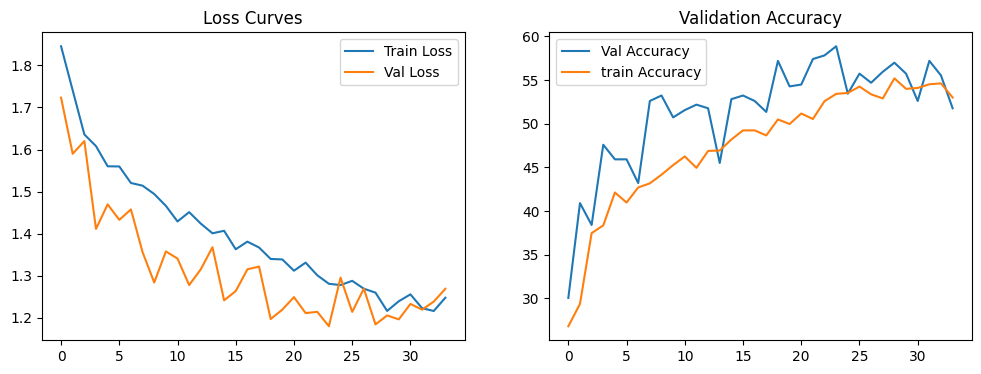

In [35]:
# Load best model
model.load_state_dict(torch.load('best_vit_model.pth'))

# Test evaluation
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')

# Plot training curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.plot(train_accuracies, label='train Accuracy')
plt.legend()
plt.title('Validation Accuracy')
plt.show()

In [40]:
import time
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

Metric          | Value     
----------------------------
Accuracy        | 0.6143
F1 Score        | 0.6152
Precision       | 0.6437
Recall          | 0.6143
Inference Time  | 0.0002s/img
FPS             | 4197.6
Model Size      | 13.02 MB


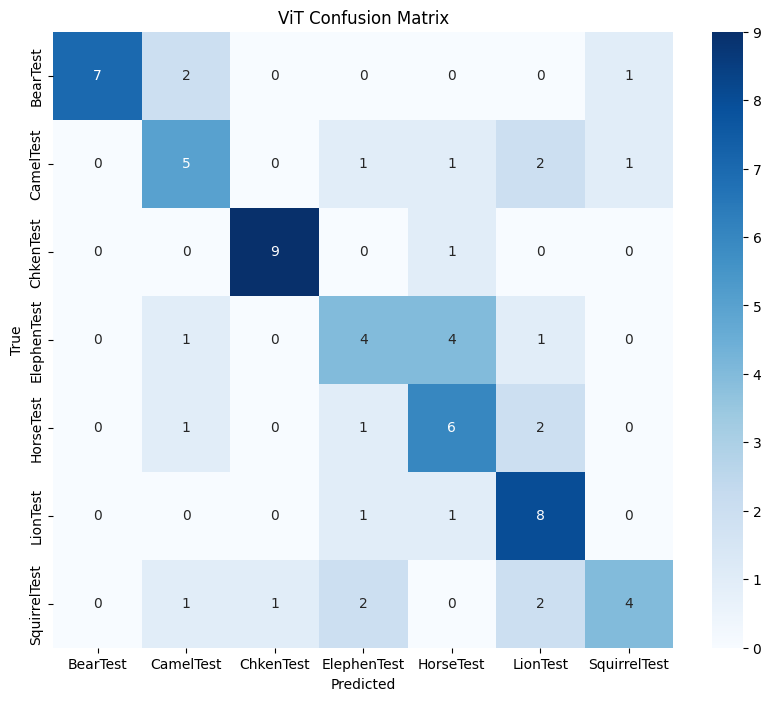

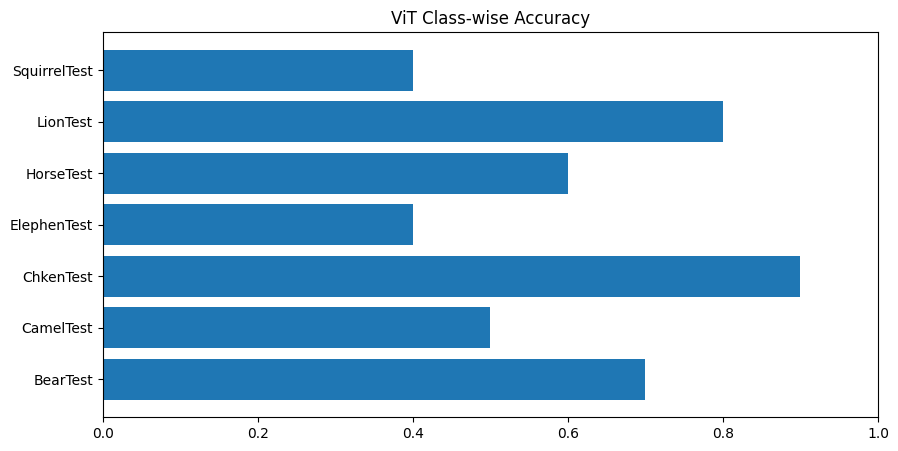


Top 5 ViT Errors:
ElephenTest→HorseTest     4
BearTest→CamelTest        2
CamelTest→LionTest        2
HorseTest→LionTest        2
SquirrelTest→ElephenTest  2


In [41]:
# Load best ViT model
model = ViT(
    image_size=image_size,
    patch_size=patch_size,
    num_classes=num_classes,
    hidden_dim=hidden_dim,
    depth=depth,
    num_heads=num_heads,
    mlp_dim=mlp_dim,
    dropout=dropout
).to(device)
model.load_state_dict(torch.load('best_vit_model.pth'))
model.eval()

# Evaluation variables
all_preds = []
all_labels = []
total_time = 0

# Main evaluation loop
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Measure inference time
        start_time = time.time()
        outputs = model(images)
        torch.cuda.synchronize()
        total_time += time.time() - start_time
        
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
cm = confusion_matrix(all_labels, all_preds)

# Performance metrics
avg_inference_time = total_time / len(test_loader.dataset)
fps = 1 / avg_inference_time
param_size = sum(p.numel() * p.element_size() for p in model.parameters()) / (1024**2)

# Print results
print(f"{'Metric':<15} | {'Value':<10}")
print("----------------------------")
print(f"{'Accuracy':<15} | {accuracy:.4f}")
print(f"{'F1 Score':<15} | {f1:.4f}")
print(f"{'Precision':<15} | {precision:.4f}")
print(f"{'Recall':<15} | {recall:.4f}")
print(f"{'Inference Time':<15} | {avg_inference_time:.4f}s/img")
print(f"{'FPS':<15} | {fps:.1f}")
print(f"{'Model Size':<15} | {param_size:.2f} MB")

# Confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=test_dataset.classes,
           yticklabels=test_dataset.classes)
plt.title('ViT Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Class-wise accuracy
class_acc = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(10,5))
plt.barh(test_dataset.classes, class_acc)
plt.title('ViT Class-wise Accuracy')
plt.xlim(0, 1)
plt.show()

# Top errors
top_errors = {}
for i in range(len(test_dataset.classes)):
    for j in range(len(test_dataset.classes)):
        if i != j and cm[i,j] > 0:
            key = f"{test_dataset.classes[i]}→{test_dataset.classes[j]}"
            top_errors[key] = cm[i,j]

print("\nTop 5 ViT Errors:")
for error, count in sorted(top_errors.items(), key=lambda x: -x[1])[:5]:
    print(f"{error:<25} {count}")